# 6.6 Sourcing & Analyzing Time-Series Data

## This script contains the following:
1. Import libraries and data
2. Time-series analysis: decomposition
3. Test for stationarity
4. Stationarizing the Data


## 1. Import libraries and data

In [126]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # handles statistical models
import os
import warnings # handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or feature.

plt.style.use('fivethirtyeight') # styling option for how your plots will appear.

In [128]:
# Configure API key 

quandl.ApiConfig.api_key = 'mutsXhyDsjVmiYyBRGqb'

In [130]:
# Import IMF Zillow

df = quandl.get('FRED/UNRATE')

In [132]:
df.head()

,Value
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [134]:
df.shape

(889, 1)

In [136]:
df.columns

Index(['Value'], dtype='object')

In [138]:
type(df)

pandas.core.frame.DataFrame

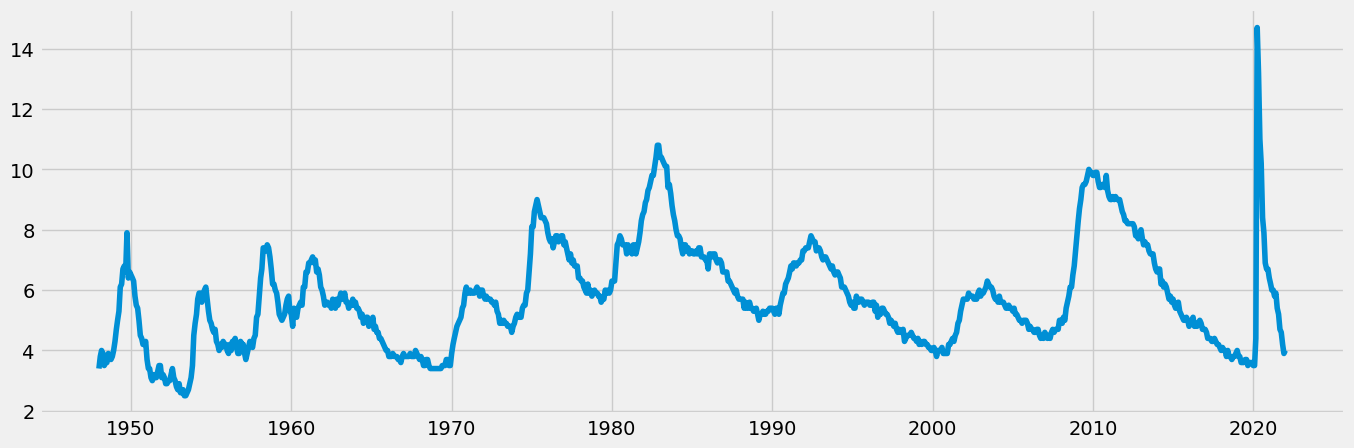

In [140]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df)

Observation: There are definite peaks and values, and there may be some minor trending going up from the 50s to the 80s, and then down to around 2000. What I think is more significant are the peaks. There are several with the biggest being in 1983, 2008, and 2020. These come at time of significant economic events, the oil embargo in the 80s, the banking crisis in the 2000s, and COVID in 2020. 

In [143]:
# Check for missing values (you shouldn't have any)

df.isnull().sum() 

Value    0
dtype: int64

## 2. Time-series analysis: decomposition

In [146]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df, model='additive')

In [148]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

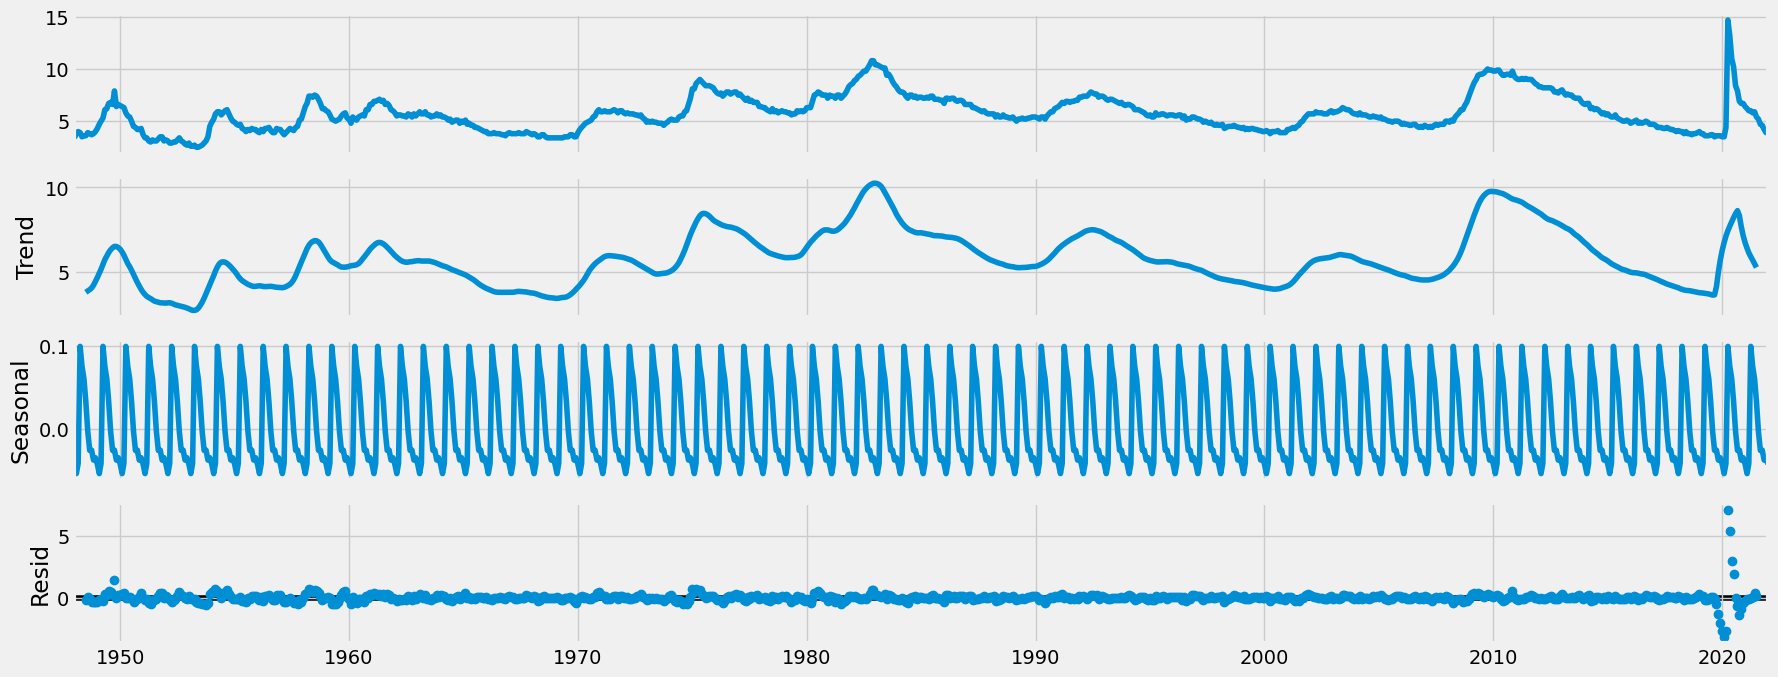

In [150]:
# Plot the separate components

decomposition.plot()
plt.show()

## 3. Test for stationarity

In [153]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.930331
p-value                          0.001823
Number of Lags Used              1.000000
Number of Observations Used    887.000000
Critical Value (1%)             -3.437744
Critical Value (5%)             -2.864804
Critical Value (10%)            -2.568508
dtype: float64


Observation: The test statistic -3.93 is smaller than the critical value at 1%: -3.437. This is the outcome that I expected.

The p-value is 0.001823, which is far less than 0.05, so the test restults are significant.

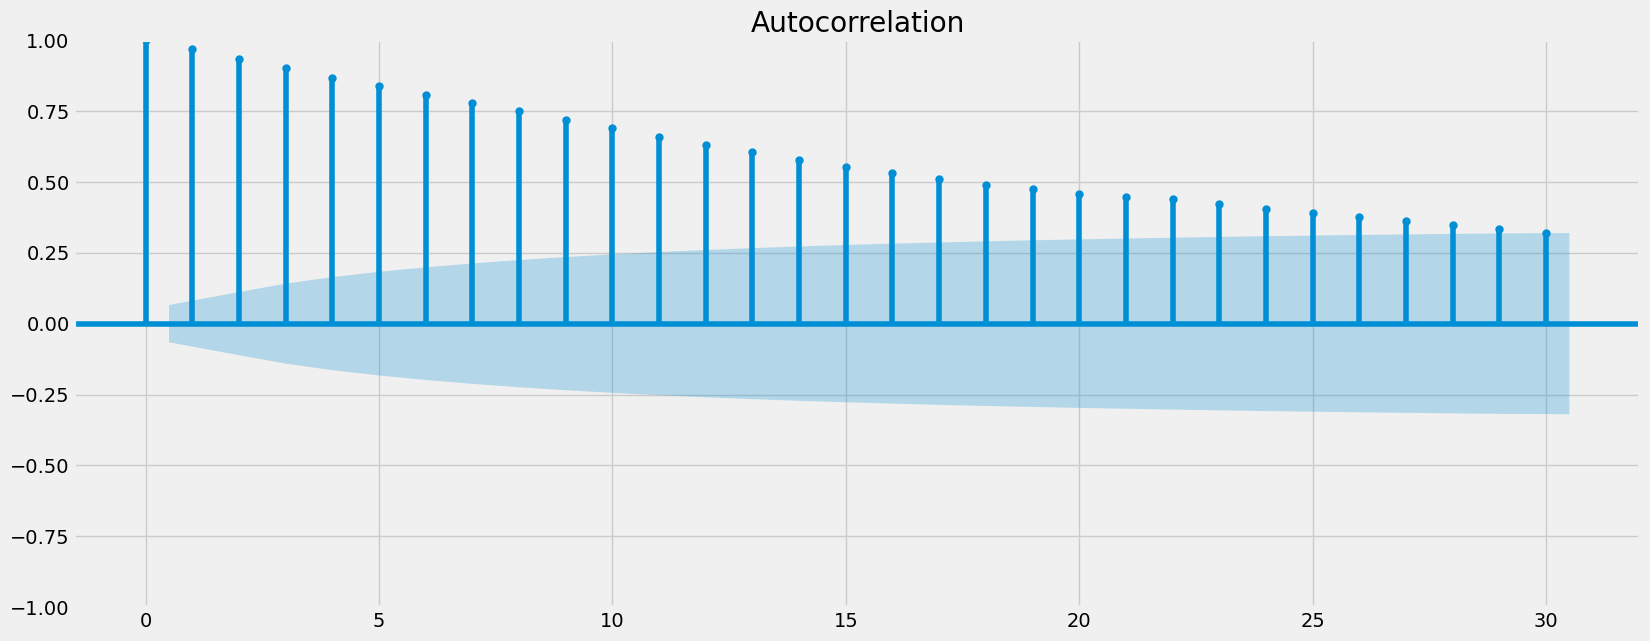

In [156]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df)
plt.show()

Observation: Unemployment data is highly autocorrelated, and the graph shows this. Every data point is outside the blue zone of the confidence interval, so it is safe to say this data is auto correlated. 

## 4. Stationarizing the Data

In [160]:
df_diff = df - df.shift(1)

In [162]:
df_diff.dropna(inplace = True)

In [164]:
df_diff.head()

,Value
Date,
1948-02-01,0.4
1948-03-01,0.2
1948-04-01,-0.1
1948-05-01,-0.4
1948-06-01,0.1


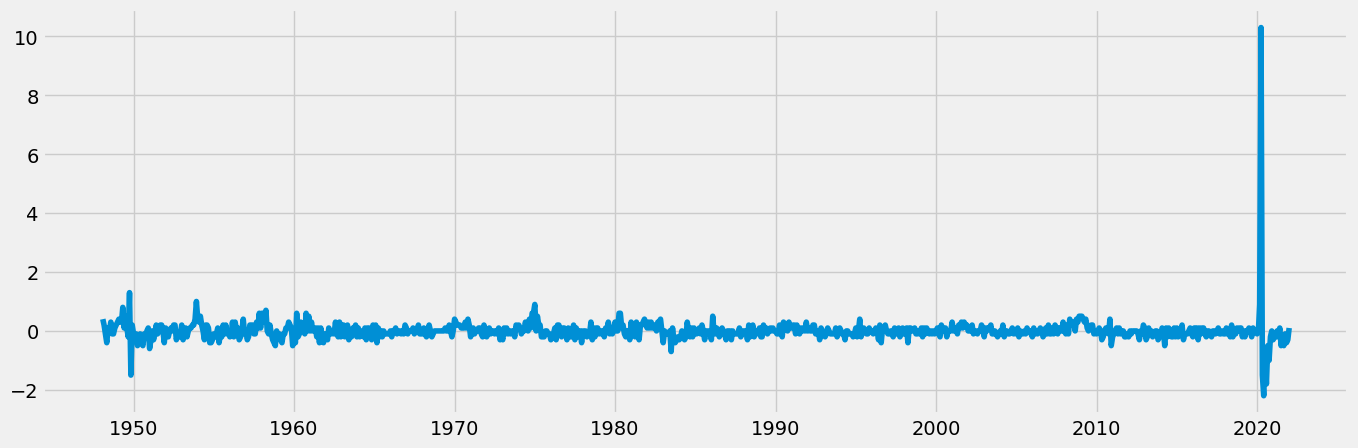

In [166]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [168]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -28.541075
p-value                          0.000000
Number of Lags Used              0.000000
Number of Observations Used    887.000000
Critical Value (1%)             -3.437744
Critical Value (5%)             -2.864804
Critical Value (10%)            -2.568508
dtype: float64


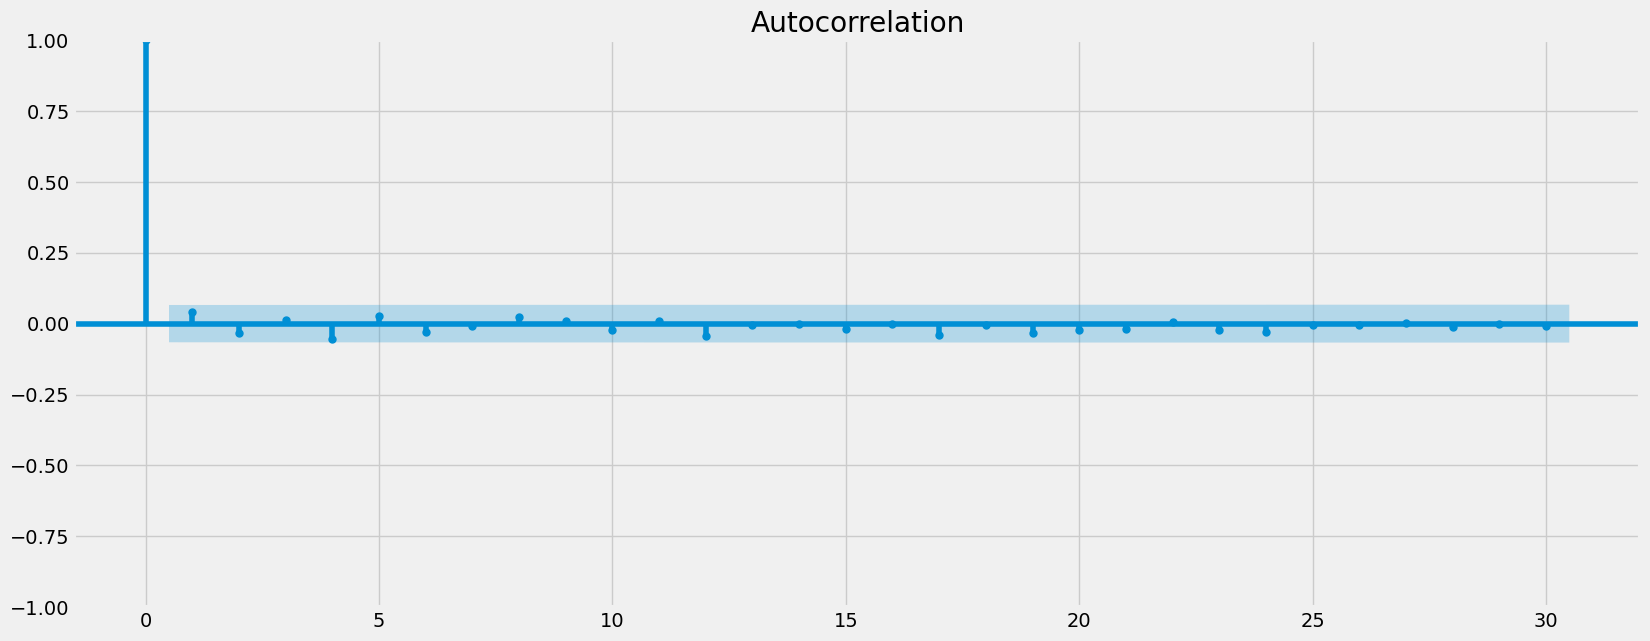

In [170]:
plot_acf(df_diff)
plt.show()

Observation: The test statistic became even smaller and the p-value went to virtually 0. Also, the autocorrelation test shows that every point except one is in the blue confidence interval.

## 5. Time series forecasting

### Define parameters

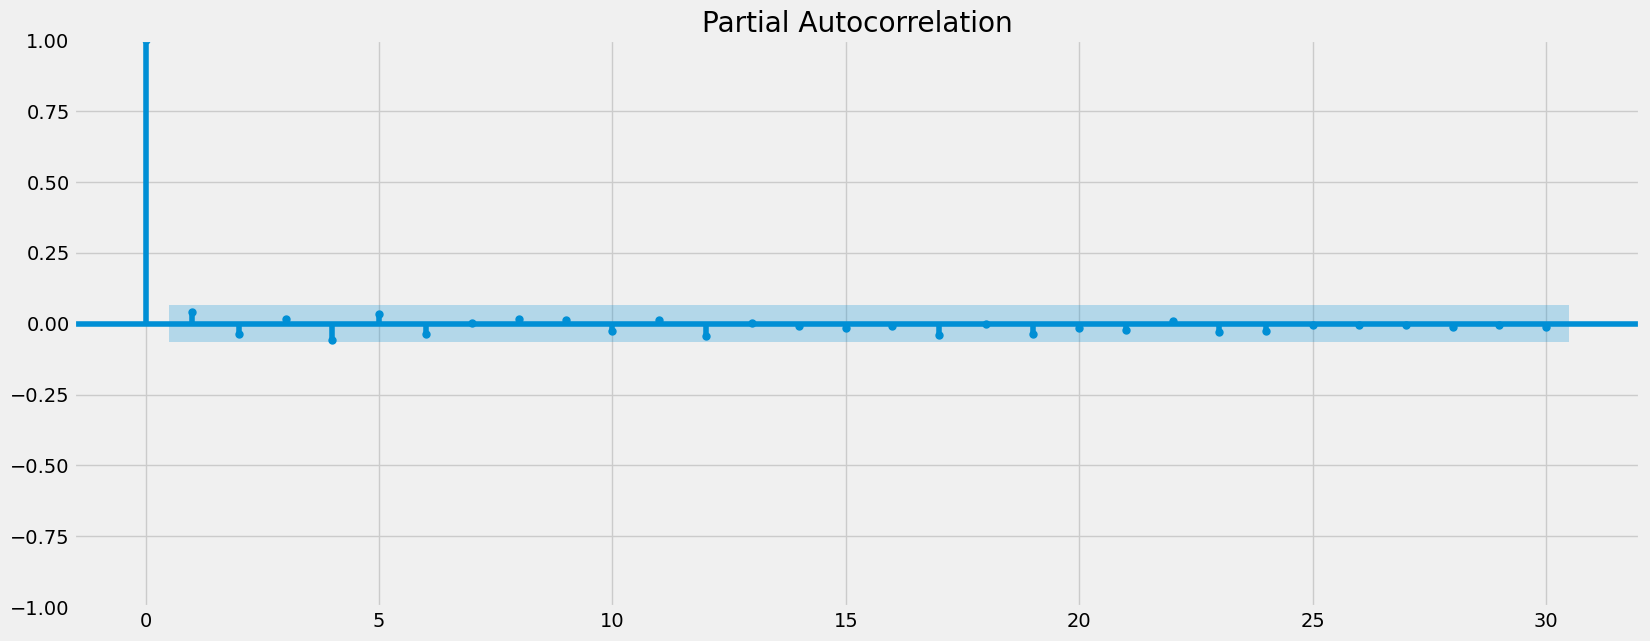

<Figure size 4500x4500 with 0 Axes>

In [175]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(df_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

This graph shows only one highly corrleated bar. This indicates a significant correlation at that point but nowhere else.

### Split the data

In [196]:
# Split the data

train = df_diff['Value'][:801]
test = df_diff['Value'][800:]

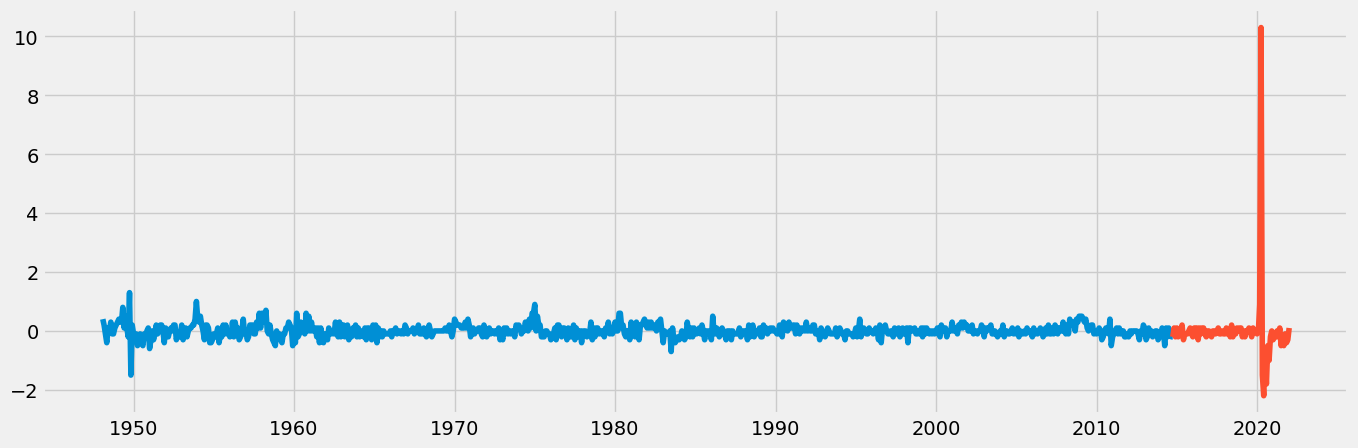

In [198]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [200]:
test.shape

(88,)

### Run and fit the model

In [186]:
from statsmodels.tsa.api import ARIMA

In [188]:
print(df.index.get_loc(df['Value'].idxmax()), df['Value'].idxmax())

867 2020-04-01 00:00:00


In [190]:
print(df.index.get_loc('2020-12-01 00:00:00'))

875


In [202]:
model = ARIMA(train, order=(5, 1, 3))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc, se, conf = fitted.forecast(88, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 37 is the shape of the test set

# Make into pandas series
se=np.std(fc)
fc_series = pd.Series(fc, index=test.index) # Creates the forecasted curve
lower = fc - 1.96 * se
upper = fc + 1.96 * se
lower_series = pd.Series(lower, index=test.index) # lower bound of the confidence interval
upper_series = pd.Series(upper, index=test.index) # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) # Creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  801
Model:                 ARIMA(5, 1, 3)   Log Likelihood                 156.803
Date:                Sat, 31 Aug 2024   AIC                           -295.606
Time:                        08:14:57   BIC                           -253.444
Sample:                    02-01-1948   HQIC                          -279.409
                         - 10-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9616      0.042    -22.837      0.000      -1.044      -0.879
ar.L2         -0.6136      0.054    -11.319      0.000      -0.720      -0.507
ar.L3          0.4789      0.046     10.316      0.0

ValueError: too many values to unpack (expected 3)

### Iterating

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  701
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 120.613
Date:                Fri, 30 Aug 2024   AIC                           -231.226
Time:                        07:48:49   BIC                           -208.471
Sample:                    02-01-1948   HQIC                          -222.430
                         - 06-01-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0246      0.024      1.034      0.301      -0.022       0.071
ar.L2          0.2642      0.037      7.187      0.000       0.192       0.336
ar.L3          0.1740      0.036      4.800      0.0

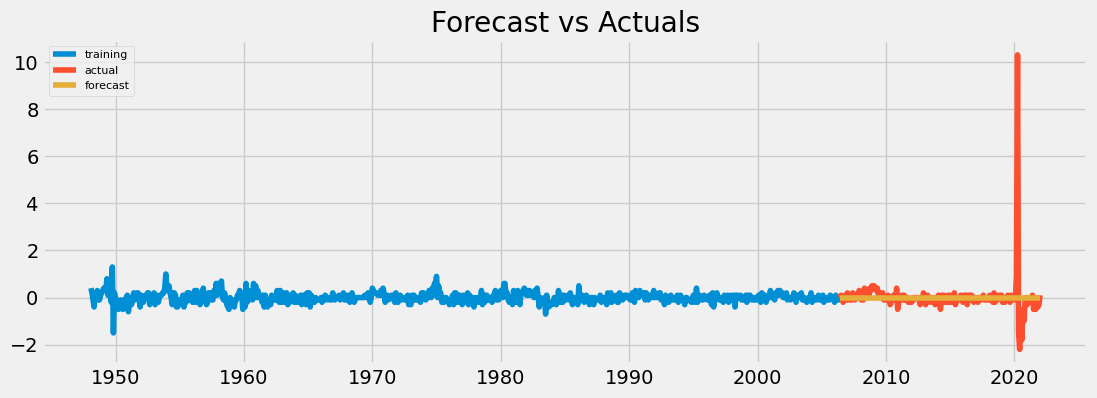

In [112]:
model = ARIMA(train, order=(3, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf

# Make into pandas series
se=np.std(fc)
fc_series = pd.Series(fc, index=test.index) # Creates the forecasted curve
lower = fc - 1.96 * se
upper = fc + 1.96 * se
lower_series = pd.Series(lower, index=test.index) # lower bound of the confidence interval
upper_series = pd.Series(upper, index=test.index) # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  701
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 101.110
Date:                Fri, 30 Aug 2024   AIC                           -194.220
Time:                        07:59:32   BIC                           -176.016
Sample:                    02-01-1948   HQIC                          -187.183
                         - 06-01-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2751      0.189     -1.457      0.145      -0.645       0.095
ma.L1         -0.6480      0.193     -3.354      0.001      -1.027      -0.269
ma.L2         -0.0279      0.154     -0.181      0.8

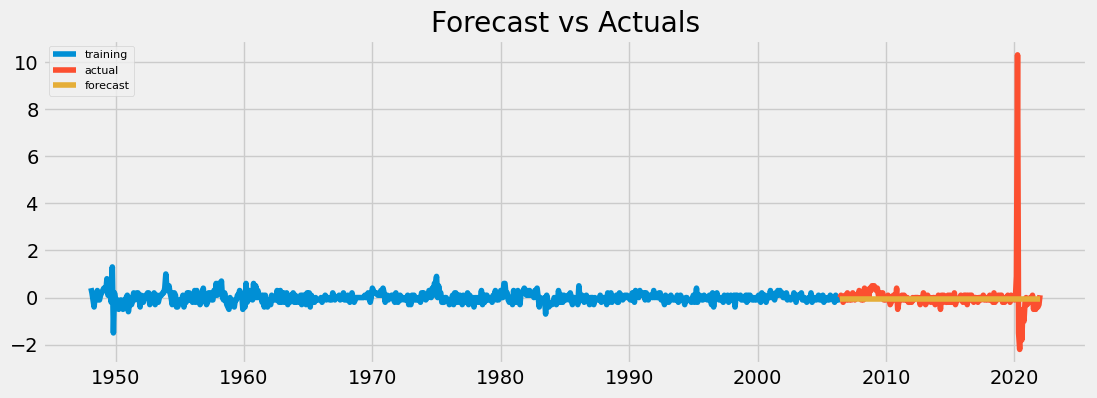

In [114]:
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf

# Make into pandas series
se=np.std(fc)
fc_series = pd.Series(fc, index=test.index) # Creates the forecasted curve
lower = fc - 1.96 * se
upper = fc + 1.96 * se
lower_series = pd.Series(lower, index=test.index) # lower bound of the confidence interval
upper_series = pd.Series(upper, index=test.index) # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  701
Model:                 ARIMA(4, 2, 1)   Log Likelihood                  94.761
Date:                Fri, 30 Aug 2024   AIC                           -177.522
Time:                        08:00:57   BIC                           -150.224
Sample:                    02-01-1948   HQIC                          -166.969
                         - 06-01-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9057      0.027    -33.150      0.000      -0.959      -0.852
ar.L2         -0.5818      0.044    -13.249      0.000      -0.668      -0.496
ar.L3         -0.3413      0.042     -8.038      0.0

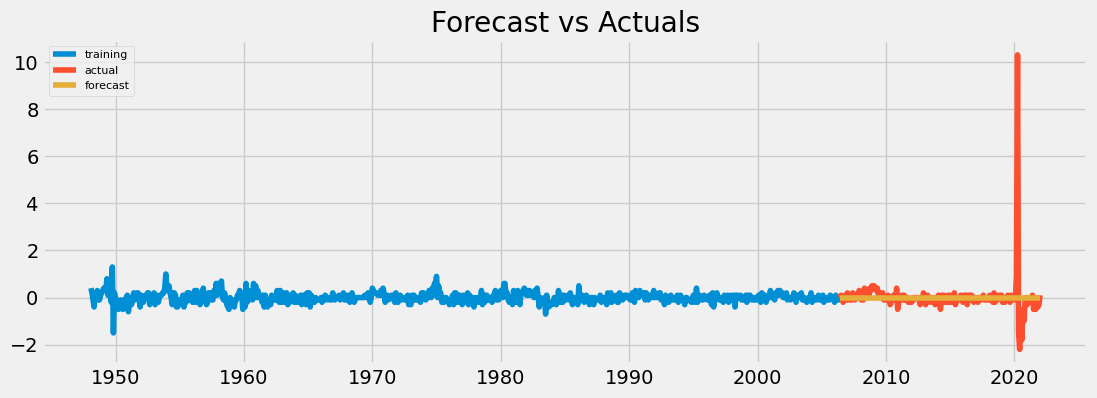

In [120]:
model = ARIMA(train, order=(4, 2, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf

# Make into pandas series
se=np.std(fc)
fc_series = pd.Series(fc, index=test.index) # Creates the forecasted curve
lower = fc - 1.96 * se
upper = fc + 1.96 * se
lower_series = pd.Series(lower, index=test.index) # lower bound of the confidence interval
upper_series = pd.Series(upper, index=test.index) # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

I changed the model order a few times and settled on p=4, d=2, and q=1. This gave me the result of all the coefficients being statistically significant (p <= 0.05).